# Advanced Data Analytics for Management Support - Assignment Submission

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Table of Contents
    1. Introduction and Data Loading
    2. Explanatory Data Analysis + Feature Selection
      2.1. Numerical Features
      2.2. Categorical Features
      2.3. Text Features
    3. Data Cleaning and Preprocessing
      3.1. Cleaning the Tabular Data
      3.2. Cleaning the Text Data
    4. Model Selection
      4.1 Models for the Tabular Data
      4.2 Models for the Text Data
    5. Creating the Final Model Architecture
    6. Conclusion

## 1 Introduction and Data Loading
In this assignment, I predict the listing prices of Airbnb listings in London using a combination of both text and tabular data. After a thorough evaluation of different models and architectures, I decided to use a stacked ensemble method. This ensemble consists of an XGBoost model to predict tabular data, a BERT model to predict text data, and a deep neural network that acts as a metamodel to combine both predictions into a final output.

I begin by conducting an exploratory data analysis in Section `2` to identify features with strong predictive capabilities. Next, in Section `3`, I clean and preprocess the data. In Section `4`, I construct multiple models and select the ones with the lowest error scores. Finally, in Section `5`, I merge the chosen models to form a final stacked ensemble model.

In [3]:
# General packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Packages for data cleaning and preprocessing
import string
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Packages for non-NN models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# General NN
import tensorflow as tf
from tensorflow.keras import layers

# BERT
!pip install "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"
# If the above does not work, use
# !pip install "tensorflow-text==2.12.*"
# !pip install "tf-models-official==2.12.*"
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
tf.get_logger().setLevel('ERROR')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


I import both the train dataset and the test dataset as a pandas DataFrame.

In [4]:
train = pd.read_csv("/content/drive/MyDrive/data/train.csv", sep=",", encoding="utf-8")
test = pd.read_csv("/content/drive/MyDrive/data/test.csv", sep=",", encoding="utf-8")

I check if the columns in the train and test sets are identical. They are, except that the price column is absent from the test set.

In [ ]:
train.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')

In [ ]:
test.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')



---



---



## 2. Explanatory Data Analysis and Feature Selection
Before starting to clean the data, it's important to examine the dataset's distribution, missing values, and outliers.

Moreover, I will evaluate the dataset's predictive ability and verify if any listings are duplicated. It's possible that some listings might appear more than once, depending on how the data was collected. To check this, I will examine if the listing ID's are duplicated. Fortunately, there seems to be no repetition of listings.

In [ ]:
train["listing_id"].duplicated().value_counts()

False    55284
Name: listing_id, dtype: int64

In the next sections of the explanatory data analysis, I take a closer look at the numerical features, the categorical features and the text data.

### 2.1 Numerical Features
I begin by creating a heatmap to show the Pearson correlation between numerical features.

This helps in two ways: firstly, it measures whether these features can predict the price by highlighting strong positive or negative correlations with the price variable. Secondly, it identifies any correlations between the features themselves. Correlated features can cause issues such as multicollinearity. In regression, when variables are highly correlated with one another, it may increase the magnitude of the standard errors, which may affect the significance of the coefficients and make it difficult to identify which variables are driving the predictions.

Strong positive correlations are represented in red, while weaker or slightly negative correlations are shown in blue. Some features do exhibit correlations with each other. Specifically, the various categories for review scores display the anticipated level of correlation. Within these scores, there is a primary review score that is prominent, namely `review_scores_rating`, alongside six more detailed review scores linked with particular aspects including location and cleanliness.

Another set of features that are correlated with each other are those associated with the property's ability to accommodate guests and its room specifications. The characteristics `accommodates`, `bedrooms`, and `beds` display a firm correlation. A higher number of listed beds often corresponds to a higher probability of multiple bedrooms and a higher capacity to accommodate guests. In combination with `bathrooms` and `guests included`, these characteristics exhibit the most significant correlation with the price, indicating their potential impact on predicting the property's worth.

<ipython-input-18-cbe460515cfc>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True,cmap=cmap)


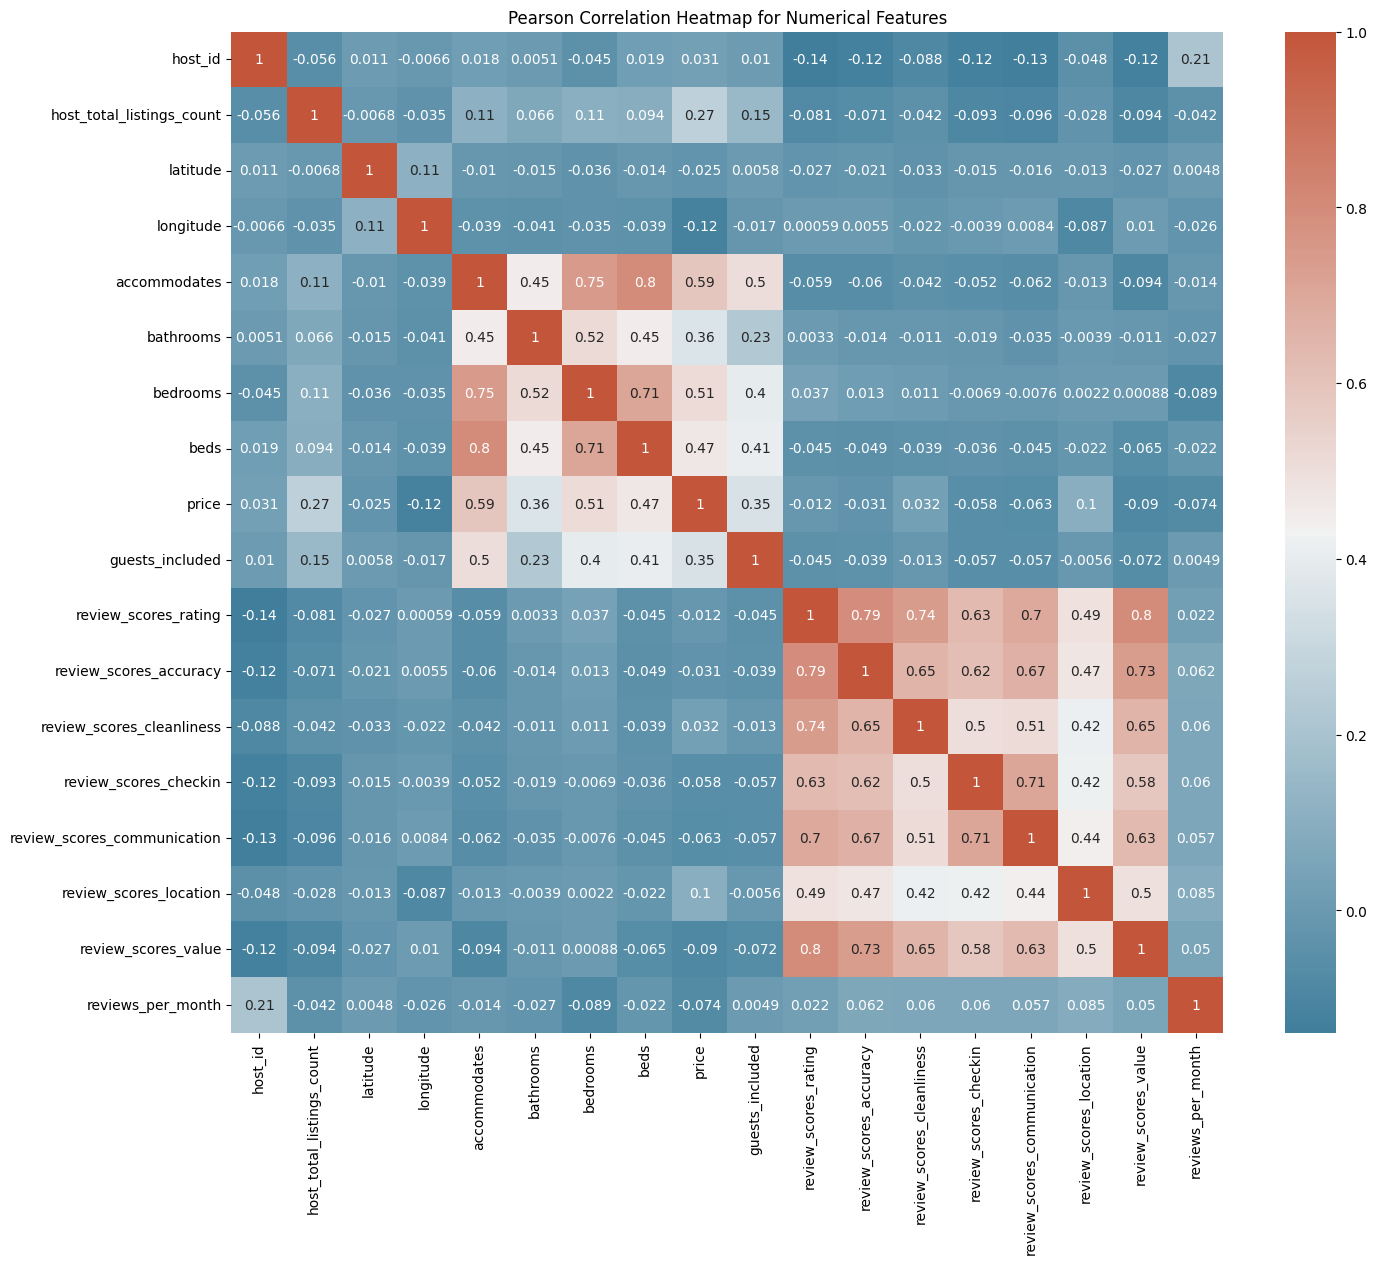

In [ ]:
plt.subplots(figsize=(16, 13))
# Custom colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Heatmap
sns.heatmap(train.corr(), annot=True,cmap=cmap)
plt.title('Pearson Correlation Heatmap for Numerical Features')
plt.show()

In the table below, the histograms of the numerical attributes are displayed.

The majority of these feature values show significant skewness. For instance, a considerable percentage of the review scores are very positive, in the 9-10 range. Furthermore, the histograms indicate the presence of possible outliers. As an instance, `host_total_listings_count` illustrates listings where the host has over 1000 properties listed.

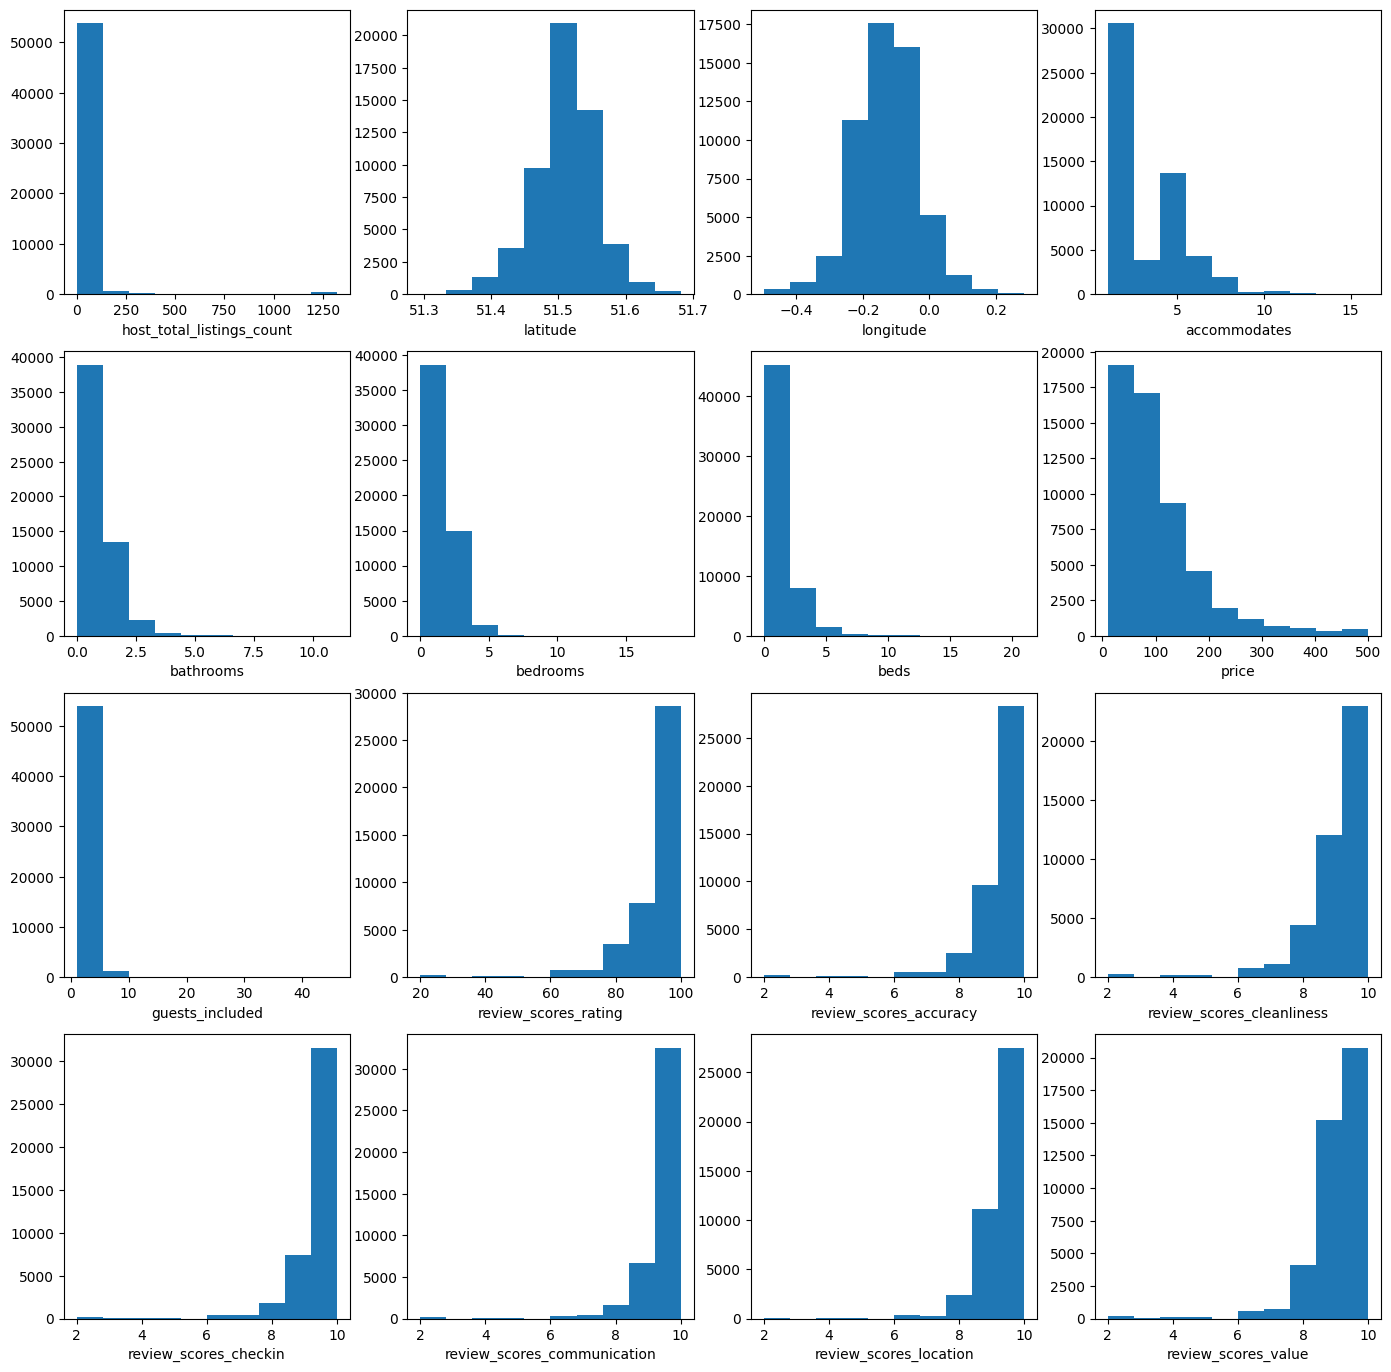

In [ ]:
rows=4
cols=4
fig,ax=plt.subplots(rows,cols,figsize=(17,17))
feat=train.select_dtypes(include=['float64','int64']).columns
feat = feat[1:]
for row in range(rows):
    for col in range(cols):
        ax[row,col].hist(train[feat[cols*row+col]])
        ax[row,col].set_xlabel(feat[cols*row+col])
plt.show()

I will now investigate the occurrence of missing data in the numerical attributes.

The most significant issue arises in relation to the reviews-linked features, which have a maximum of 24.39% missing values.  This is particularly evident when reviewing `reviews_per_month`, which fails to acknowledge instances where the value is zero. It is therefore likely that the absence of reviews is not random and not due to an error. They are likely missing because there are simply no reviews for that month.

In [ ]:
print('Sum of missing values per numerical feature:\n',train.select_dtypes(include=['float64','int64']).isna().sum())
print('----------------\n',f'At most {round(train.review_scores_checkin.isna().sum()/len(train)*100,2)}% of the observations are missing.')
print('----------------\n',f'reviews_per_month does not feature 0s. The smallest value is {train.reviews_per_month.min()}.')

Sum of missing values per numerical feature:
 host_id                            0
host_total_listings_count        111
latitude                           0
longitude                          0
accommodates                       0
bathrooms                         70
bedrooms                          62
beds                             262
price                              0
guests_included                    0
review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
review_scores_checkin          13483
review_scores_communication    13446
review_scores_location         13480
review_scores_value            13480
reviews_per_month              12380
dtype: int64
----------------
 At most 24.39% of the observations are missing.
----------------
 reviews_per_month does not feature 0s. The smallest value is 0.01




---



### 2.2 Categorical Features
In this section I analyze the categorical features. I cover `host_is_superhost`, `host_has_profile_pic`, `host_identity_verified`, `neighbourhood_cleansed`, `property_type`, `room_type`, `bed_type`, and `cancellation_policy`.

To assess the correlation between categorical variables, the Cramer's V metric is utilized. Cramer's V coefficients do not consider negative values unlike Pearson's correlation. This is because Cramer's V coefficients are designed to measure the strength of associations regardless of their direction.  Negative association is not as applicable to categorical variables as it is to numerical variables, where negative correlation indicates an inverse relationship.

Of all the categorical variables, room type appears to have the most impact, with a Cramer's V coefficient of 0.23. One possible reason for this observation could be a notable price disparity among the different room types.

It should be noted that a low Cramer's V value does not necessarily indicate a lack of relevance to the target variable. Nevertheless, it is a useful approach to pinpoint the most significant features.

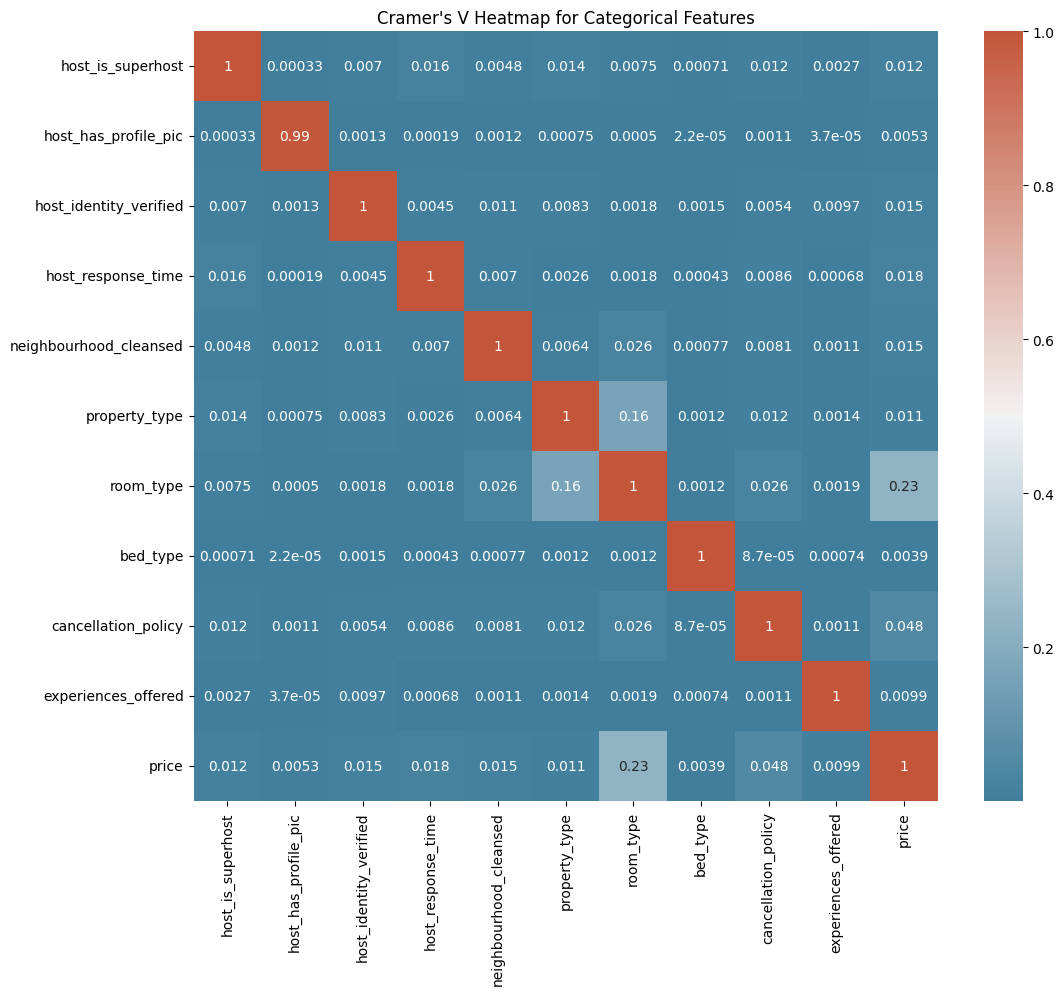

In [ ]:
# Create a function to calculate Cramer's V
def cramers_V(var1,var2) :
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  chi2 = stats.chi2_contingency(crosstab)[0]
  num = np.sum(crosstab)
  minval = min(crosstab.shape)-1
  return (chi2/(num*minval))

variables = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type','cancellation_policy','experiences_offered', 'price']
cramer_matrix = np.zeros((len(variables), len(variables))) # initialize an empty matrix

for i in range(len(variables)):
    for j in range(len(variables)):
            cramer_matrix[i, j] = cramers_V(train[variables[i]], train[variables[j]]) # Iterate over all variable combinations

# Plot the heatmap
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cramer_matrix, annot=True, cmap=cmap, xticklabels=variables, yticklabels=variables)
plt.title('Cramer\'s V Heatmap for Categorical Features')
plt.show()

After creating a heatmap to evaluate the relationships between the features and the target variable, a thorough analysis of each individual feature is carried out.

It is crucial to highlight that the majority of the dataset's hosts possess a profile picture, with only a small portion lacking one.  Hence, it is probable that this attribute carries little to no significant information. This feature will, therefore, be disregarded during the data cleaning phase. On the contrary, characteristics such as `host_is_superhost` and `host_identity_verified` do not exhibit such tendencies.

In [ ]:
print(train.host_has_profile_pic.value_counts())
print(train.host_is_superhost.value_counts())
print(train.host_identity_verified.value_counts())

t    55013
f      160
Name: host_has_profile_pic, dtype: int64
f    46982
t     8191
Name: host_is_superhost, dtype: int64
f    35346
t    19827
Name: host_identity_verified, dtype: int64


The price distribution remains remarkably consistent across categories for host_is_superhost, host_identity_verified, and host_response_time. Due to this uniformity, I have decided to eliminate these variables during the data cleaning process as well.

<ipython-input-8-0e40221baf50>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


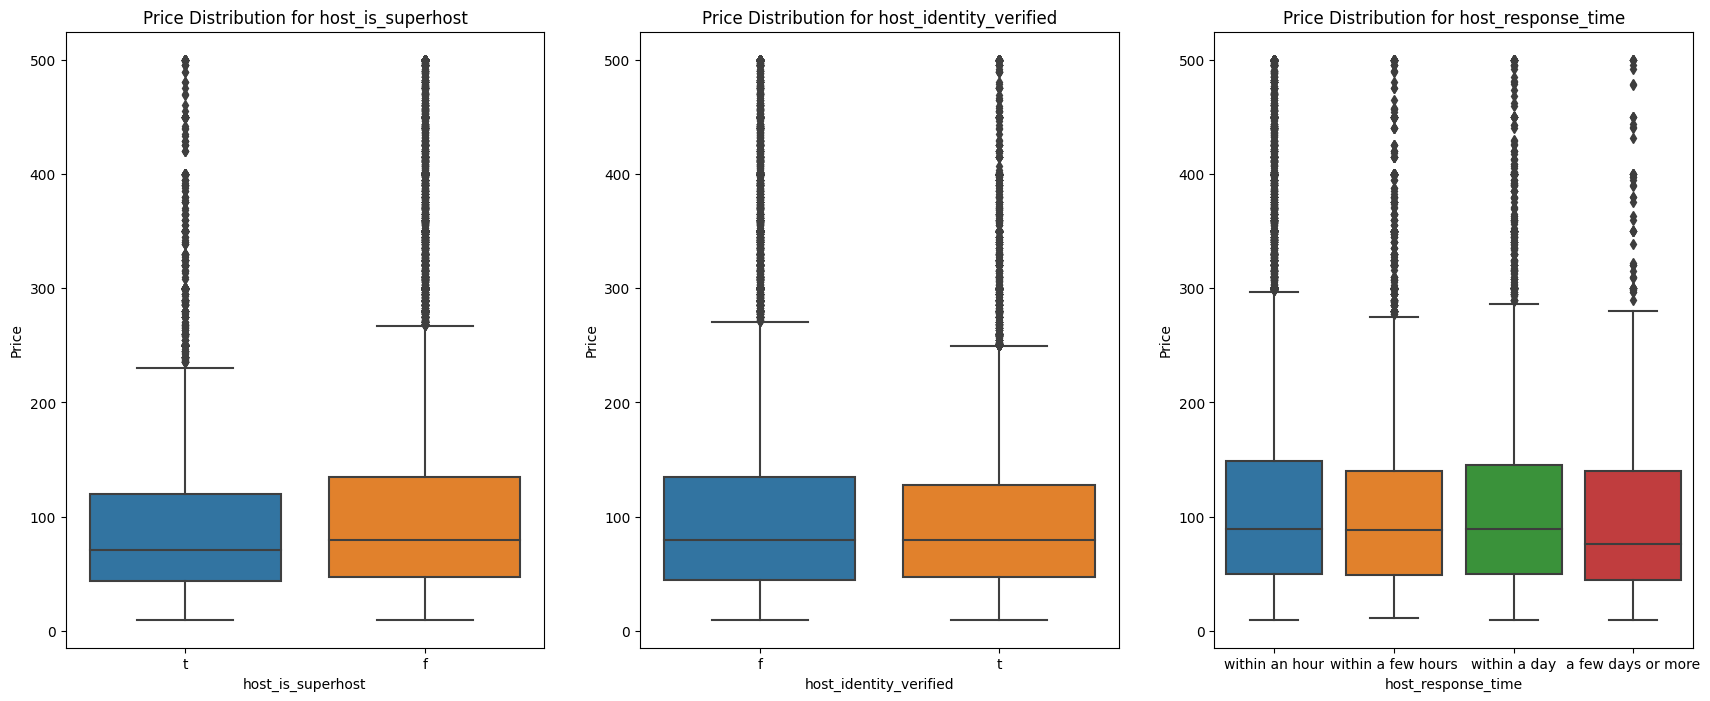

In [ ]:
plt.subplots(figsize=(21, 8))
plt.subplot(1, 3, 1)
sns.boxplot(x='host_is_superhost', y='price', data=train)
plt.xlabel('host_is_superhost')
plt.ylabel('Price')
plt.title('Price Distribution for host_is_superhost')
plt.subplot(1, 3, 2)
sns.boxplot(x='host_identity_verified', y='price', data=train)
plt.xlabel('host_identity_verified')
plt.ylabel('Price')
plt.title('Price Distribution for host_identity_verified')
plt.subplot(1, 3, 3)
sns.boxplot(x='host_response_time', y='price', data=train)
plt.xlabel('host_response_time')
plt.ylabel('Price')
plt.title('Price Distribution for host_response_time')
plt.show()

While the Cramer's V coefficient for `neighbourhood_cleansed` may appear relatively small, a closer examination of the price distribution for each neighbourhood suggests that it may actually contain valuable information. Although the majority of neighbourhoods have similar price distributions, there are a few exceptions where the price distributions are significantly different. Listings connected to property in the city center tend to be more expensive than those in the suburbs.

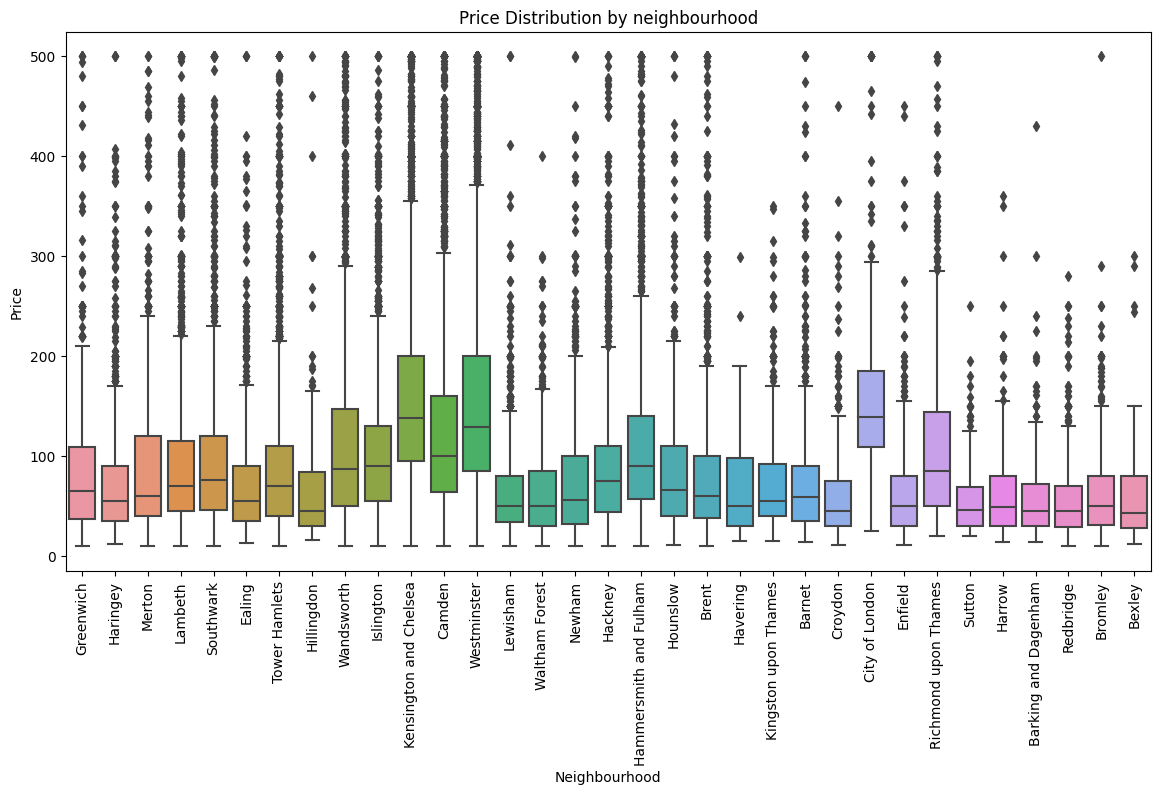

In [6]:
plt.subplots(figsize=(14, 7))

ax = sns.boxplot(x='neighbourhood_cleansed', y='price', data=train)
plt.xlabel('Neighbourhood')
plt.ylabel('Price')
plt.title('Price Distribution by neighbourhood')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show();

Inspecting the `neighbourhood` feature reveals that it shows more fine grained distinctions of the neighbourhoods, districts and boroughs. Because of the high dimensionality of this feature, I choose the cleaned version.

In [ ]:
train['neighbourhood'].value_couts

Upon closer inspection of the `property_type` feature, it becomes clear that it poses certain challenges. This is because it contains categories that are exclusive to either the training or the test set, such as 'Windmill' or 'Island'. However, similar to the `neighbourhood_cleansed` variable, it may still contain valuable information, as the price distributions of different property types show variations.

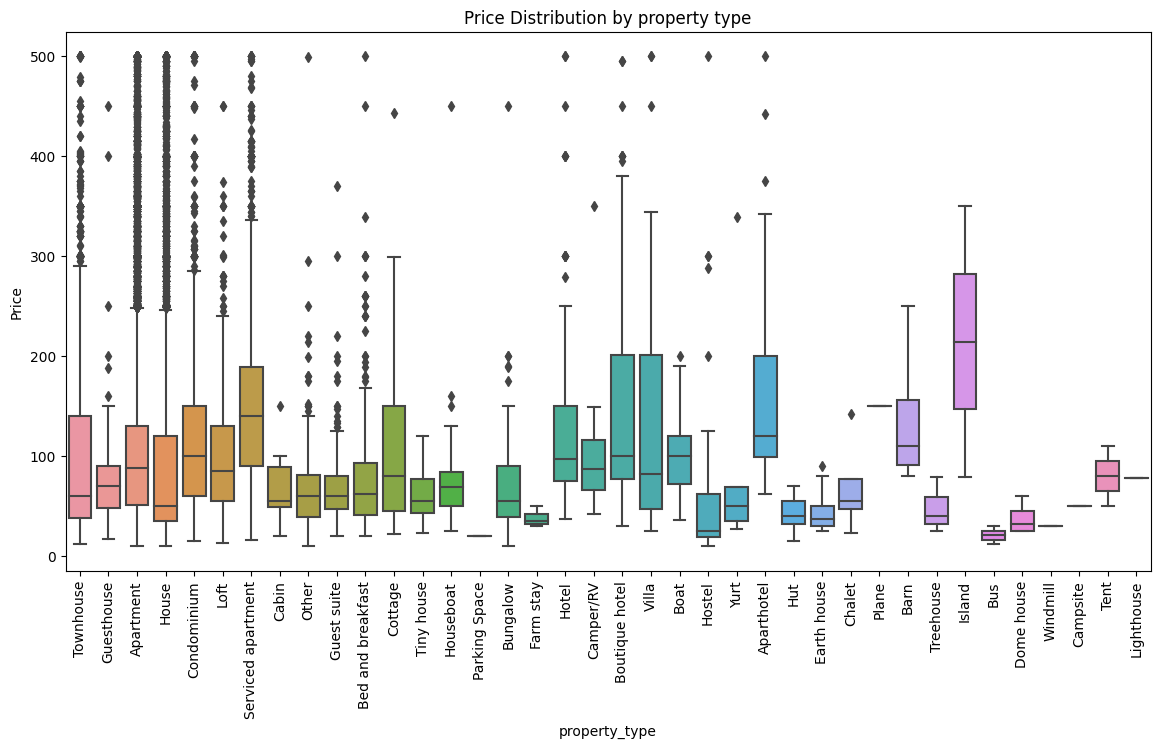

----------------
 Differing Categories of property_type for the test and train dataset: {'Minsu (Taiwan)', 'Dome house', 'Windmill', 'Parking Space', 'Lighthouse', 'Ryokan (Japan)', 'Island', 'Treehouse', 'Plane', 'Casa particular (Cuba)', "Shepherd's hut (U.K., France)", 'Tent'}


In [ ]:
plt.subplots(figsize=(14, 7))

ax = sns.boxplot(x='property_type', y='price', data=train)
plt.xlabel('property_type')
plt.ylabel('Price')
plt.title('Price Distribution by property type')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show();

print('----------------\n Differing Categories of property_type for the test and train dataset:', set(train['property_type']).symmetric_difference(set(test['property_type'])))

Plotting the price distribution by room type reveals that shared rooms are mostly the cheapest type, followed by private rooms. As to be expected, renting entire homes or appartments is relatively costly, only topped by hotel rooms.

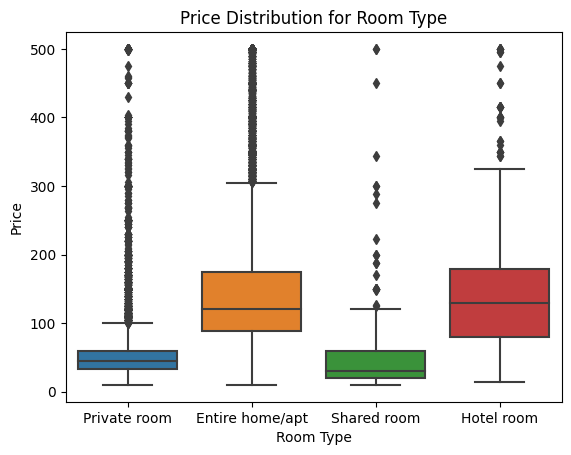

In [5]:
sns.boxplot(x='room_type', y='price', data=train)
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.title('Price Distribution for Room Type')
plt.show()

A look at `bed_type` reveals that the vast majority of observations list real beds, only a small fraction, at most 0.4% of all observations, list other bed types. As such I will remove this feature.

In [ ]:
print(train['bed_type'].value_counts())

Real Bed         54864
Pull-out Sofa      239
Futon              116
Couch               38
Airbed              27
Name: bed_type, dtype: int64


The feature `cancellation_policy`is problematic, because it includes two categories, that are only present in the training set. This is problematic as some models have difficulties with not seeing all categories during fitting or prediction.

In [ ]:
print(train['cancellation_policy'].value_counts())
print('----------------\n Differing Categories of cancellation_policy for the test and train dataset:', set(train['cancellation_policy']).symmetric_difference(set(test['cancellation_policy'])))

strict_14_with_grace_period    24102
flexible                       17094
moderate                       13643
super_strict_60                  230
super_strict_30                  211
strict                             2
luxury_moderate                    1
luxury_super_strict_95             1
Name: cancellation_policy, dtype: int64
----------------
 Differing Categories of cancellation_policy for the test and train dataset: {'luxury_moderate', 'luxury_super_strict_95'}


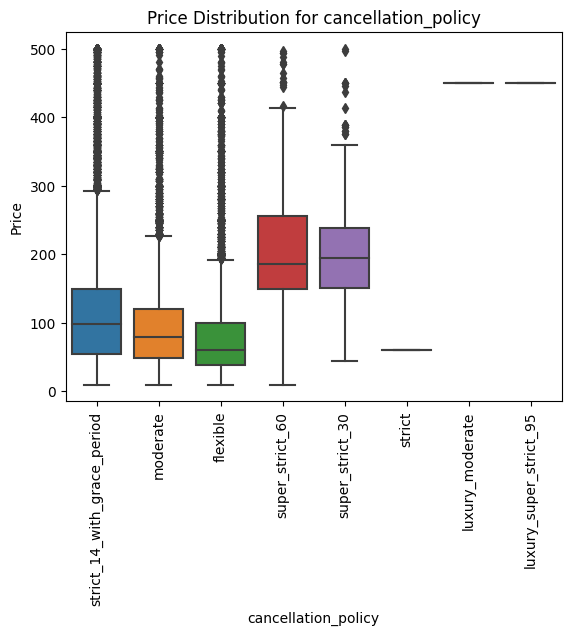

In [7]:
ax = sns.boxplot(x='cancellation_policy', y='price', data=train)
plt.xlabel('cancellation_policy')
plt.ylabel('Price')
plt.title('Price Distribution for cancellation_policy')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

`experiences_offered` likely does not carry information or atleast not a lot, considering that more than 98% of the features offer no specific experience.

In [ ]:
train.experiences_offered.value_counts()

none        54222
business      364
family        300
social        266
romantic      132
Name: experiences_offered, dtype: int64



---



### 2.3 Text Features
In this Section, I will take a closer look at the texts. Since the features are strings, it will be difficult to determine their actual importance in predicting the price.

I will start by examining the content of the features. Although most of the feature names are unique, I do this to ensure that I am not making biased assumptions.

The text features are:
*   `name`: listing name
*   `summary`: Summary of the listing content
*   `space`: Description of rooms
*   `description`: Description of the entire property
*   `neighborhood_overview`: Description of the neighbourhood
*   `transit`: Description of available public transport etc.
*   `house_rules`: Host's rules for guests
*   `amenities`: List of available amenities

While examining the features, it becomes apparent that the various amenities are often already included in the `summary` and `description`. For this reason, I will drop `amenities`.

In [ ]:
features = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'transit', 'house_rules','amenities']
for feature in features:
  print(f"Content of '{feature}': {train[feature][1]}")

Content of 'name': Lovely Garden Studio Private Access
Content of 'summary': Garden studio with private entrance, 5 minutes from Crouch End & its many shops & restaurants. All modern amenities - free high speed wifi, FreeviewTV, High pressure shower, comfy King bed, toaster/kettle/fridge. Lots of room and very quiet!
Content of 'space': Beautiful studio with a king size bed, a sofa & coffee table.  Little kitchen area, equipped with a toaster, kettle, fridge, and cups, bowls, cutlery plates & biscuits! Light, self-service breakfast provided. Nice lighting and art, and a place for your suitcase and to hang your clothes. Blackout curtains for peaceful sleep.
Content of 'description': Garden studio with private entrance, 5 minutes from Crouch End & its many shops & restaurants. All modern amenities - free high speed wifi, FreeviewTV, High pressure shower, comfy King bed, toaster/kettle/fridge. Lots of room and very quiet! Beautiful studio with a king size bed, a sofa & coffee table.  Litt

Now that I know the content of the text feature, I examine the texts for their word count. The shortest texts are, as expected, in the `name` feature, with a maximum length of only 45, while the average length is about 6.5. The longest texts on average are in the `description`, with a maximum length of 221.

In [ ]:
def count_words(text):
    words = str(text).split()
    return len(words)

for feature in features:
  print(f"{feature}'s word count description:\n {train[feature].apply(count_words).describe()}\n-----------------------------------")

name's word count description:
 count    55284.000000
mean         6.451740
std          1.970287
min          1.000000
25%          5.000000
50%          7.000000
75%          8.000000
max         45.000000
Name: name, dtype: float64
-----------------------------------
summary's word count description:
 count    55284.000000
mean        55.227299
std         27.862124
min          1.000000
25%         37.000000
50%         57.000000
75%         78.000000
max        191.000000
Name: summary, dtype: float64
-----------------------------------
space's word count description:
 count    55284.000000
mean        57.764507
std         61.486125
min          1.000000
25%          1.000000
50%         35.000000
75%         98.000000
max        209.000000
Name: space, dtype: float64
-----------------------------------
description's word count description:
 count    55284.000000
mean       132.583514
std         56.906259
min          1.000000
25%         85.000000
50%        163.000000
75%     



---



---



## 3. Data Cleaning and Preprocessing
In this Section, I clean both tabular data and text data. I describe the decision making process, the reasoning behind the choices and the operations in detail. I start by cleaning the tabular data.
### 3.1. Cleaning the Tabular Data
I construct a tabular data preprocessing function that does the following:
1. **Removing Unnecessary Features:** First, I remove columns that do not seem relevant to our analysis. This is important because it simplifies the data set and reduces unnecessary complexity as I want to focus on the most important data. As such I exclude `picture_url` and the other variables related to the location of the property that are not `neighbourhood_cleansed`: `zipcode`,`longitude`,`latitude`, and `neighbourhood` . These variables likely not carry more information than `neighbourhood_cleansed` and might even be closely related to eachother. I drop `experiences_offered` and `bed_type` as they carry negligible information. Since I already include the number of `bedrooms`, I drop `beds` altogether. I found during model selection that bedrooms already carries the vast majority of the information. As discussed in Section 2.2. I remove `host_is_superhost`, `host_has_profile_pic` and `host_identity_verified`. `review_scores_rating` is also dropped. Since the feature is most likely a combination of the other review features, it is likely that the information is already included in the other features. However, it could be argued that because the feature is usually the first to be seen by customers, it has a greater prominence. But during the model selection process, I discovered that the feature is one of the less important review features. I also drop `amenities` while selecting the models, I also used this feature, but it did not significantly improve the accuracy and since the information is often already included in other text features, I deem it unnecessary.

2. **Handling 'host_since' Date Feature:** Next, I clean `host_since`, which represents the registration date of hosts. I convert it to only show the year. Additionally, I fill in any missing registration years with mode. This way, I don't lose valuable information about the feature.

3. **Handling 'host_response_rate' Feature:** The `host_response_rate` column is processed by removing percentage symbols and converting it to a float. I then fill in missing values with the median response rate. Because of the percentage symbols the feature was orginally a string.

4. **Handling 'host_response_time' Feature:** For missing values in the `host_response_time` column, I replace them with `not given`. This makes the data more consistent and I don't introduce a bias.

5. **Handling 'reviews_per_month' Feature:** In the `reviews_per_month` column, I fill missing values with zeros. This is based on the assumption that a missing values mean listings have no reviews.

6. **Handling Numeric Features:** Several columns with numeric values, such as 'host_total_listings_count' and review scores, have missing values. To address this, I fill in these gaps with the median values for each respective column. I could have also created a mini model, such as a linear regression, to predict the missing values. I decided against it, because using the median allows for a faster processing. Furthermore, most of the missing values likely stem from the fact that a listing had no reviews to begin with - this means they are not missing at random. I could have also used values that our out of bounds (for example negative values) to encode the missingness, but this could also reduce prediction scores. As such I chose the less invasive and the fast method of imputing with the median. I chose the median, because the scores are skewed toward higher values and the median can result in better scores than the mean in these cases.

7. **Reducing Dimensionality:** To reduce the dimensionality of the dataset, I group infrequent (less than 0.5% of all observations) categories in `property_type` as 'Other' and the infrequent categories in `cancellation_policy` with the mode. This simplifies the data while retaining meaningful information. I also do this, because both features include categories that are unique to the training or the test set respectively. Many models cannot handle not seeing categories predicting that were seen during training and vice versa.

8. **Replacing Remaining Missing Values with Empty Spaces**: I replace the missing values in the text features with white space. I do this in this section, because the BERT model used in Section 4.2 does not require text processing and I will apply the text processing to a new data frame.

9. **Data Type Conversion:** Lastly, I ensure that the data types for each column are appropriate. For example, I convert counts to integers and specify category types for categorical variables. I do this so that all functions behave correctly.

I considered some other feature engineering during the preprocessing phase. It might have been a viable strategy to group several categories of `neighborhood_cleansed` based on location, e.g. into 'city center' and 'suburbs', but keeping in mind that the dataset is comparatively small, I opted against it. The models will likely not take too much longer to process with the higher dimensionality in the feature, but can lead to more accurate results.

During the data cleaning process I chose not to handle possible outliers. When handling outliers it's important to understand why they exist. Sometimes outliers can stem from a faulty data gathering process. In the case of this data set, I doubt that they are mistakes. The review scores are all within their respective ranges (0-10) and although there exists atleast one host with a total of 1000 or more listings, I don't deem this unlikely. One could have employed outlier handling methods, such as winsorizing and the linear model I use for predicting the price on the tabular data, will likely perform less well because of the extreme values. However, the ensemble models, namely Random Forest and XGBoost, are not as sensitive to outliers and might even perform worse after handling them. Considering the chosen models, it should not be important to handle extreme values.

In [ ]:
def tabular_preprocessing(df):
    # Remove the weakest features
    df.drop(columns=['picture_url','zipcode', 'host_id','longitude','latitude',
                     'neighbourhood','experiences_offered','bed_type', 'beds',
                     'host_is_superhost','host_has_profile_pic',
                     'host_identity_verified','review_scores_rating','amenities'],
            inplace=True)

    # Convert host_since to year
    df['host_since'] = pd.to_datetime(df['host_since'])
    df['host_since'] = df['host_since'].dt.strftime('%Y')
    df['host_since'].fillna(df['host_since'].mode()[0], inplace=True)

    # Impute host_response_rate with mean
    df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
    df['host_response_rate'] = df['host_response_rate'].astype('float') / 100
    df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace=True)

    # Replace missing values in host_response_time with 'not given'
    df['host_response_time'].fillna('not given', inplace=True)

    # Fill missing values in 'reviews_per_month' with 0 and convert to int
    df['reviews_per_month'].fillna(0, inplace=True)

    # Replace missing review scores with median and convert to int
    for feature in ['host_total_listings_count', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location',
                    'review_scores_value', 'bathrooms', 'bedrooms']:
        df[feature].fillna(df[feature].median(), inplace=True)
        df[feature] = df[feature].astype('int')

    # Reduce dimensions by assigning 'Other' to categories in 'property_type' that occur less than 0.5% of all categories
    series = df['property_type'].value_counts()
    df['property_type'] = np.where(df['property_type'].isin(series[(series/sum(series)).lt(0.005)].index),
                                   'Other',df['property_type'])

    # Reduce dimensions by assigning the mode of 'cancellation policy' to categories that occur less than 0.5% of all categories
    series = df['cancellation_policy'].value_counts()
    df['cancellation_policy'] = np.where(df['cancellation_policy'].isin(series[(series/sum(series)).lt(0.005)].index),
                                         df['cancellation_policy'].mode()[0], df['cancellation_policy'])

    # Fill remaining missing values with empty strings
    df.fillna(value='', inplace=True)

    # Convert 'host_since' to int
    df['host_since'] = df['host_since'].astype('int')
    df['host_response_time'] = df['host_response_time'].astype('category')
    df['reviews_per_month'] = df['reviews_per_month'].astype('int')
    df['cancellation_policy'] = df['cancellation_policy'].astype('category')
    df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype('category')
    df['property_type'] = df['property_type'].astype('category')
    df['room_type'] = df['room_type'].astype('category')

Now that the preprocessing function is complete, I apply it to both the training and the test set. It is important that all data sets are cleaned the same way. Inconsistent preprocessing can result in disparities in data distributions across the training and test sets, lowering model performance. The goal of machine learning is being able to generalize well on unseen data. By applying the same cleaning process to both the training and testing sets, it is ensured that the model learns patterns and relationships that remain consistent across all data.

In [ ]:
# Apply preprocessing to both data sets
tabular_preprocessing(train)
tabular_preprocessing(test)

The tabular data cleaning process successfully dealt with the missing values and applied the correct data types to the features.

In [12]:
# Check for missing values
print('Sum of missing values per tabular feature in the test set:\n',train.select_dtypes(include=['float64','int64','category']).isna().sum(),'\n-----------------------------------')
print('Sum of missing values per tabular feature in the test set:\n',test.select_dtypes(include=['float64','int64','category']).isna().sum(),'\n-----------------------------------')
print(train.info(),'\n-----------------------------------')
print(test.info())

Sum of missing values per tabular feature in the test set:
 host_id                            0
host_total_listings_count        111
latitude                           0
longitude                          0
accommodates                       0
bathrooms                         70
bedrooms                          62
beds                             262
price                              0
guests_included                    0
review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
review_scores_checkin          13483
review_scores_communication    13446
review_scores_location         13480
review_scores_value            13480
reviews_per_month              12380
dtype: int64 
-----------------------------------
Sum of missing values per tabular feature in the test set:
 host_id                           0
host_total_listings_count        65
latitude                          0
longitude                         0
accommodates        



---



### 3.2. Cleaning the Text Data
The function 'get_wordnet_pos' determines a words part-of-speech (POS) tag by its first character to aid in lemmatization. For example, "J" is mapped to ADJ (adjective) and "N" to NOUN. If the POS tag is unrecognized, it defaults to NOUN.

'lemmatize_and_filter_stopwords' takes the different sentences of the text data as input. The function removes stop words and lemmatizes the words within the sentence. Stop words are words that do not carry important information and appear comparably often. Examples for stop words are words such as: 'that', 'it', 'and' etc. Lemmatizing reduces words to their fundamental and simplest form.

Another option could have been to apply stemming instead of lemmatization. Stemming reduces words to their base form. The main difference is that lemmatization results in actual words, while stemming can lead to replacements that are not actually words. Lemmatization is more computationally taxing and requires dictionaries to work, but it often results in better accuracy and interpretability.

The actual data cleaning process is done using the function 'text_preprocessing'. It is applied to `name`, `summary`, `space`, `description`,`neighborhood_overview`,`transit` and `house_rules`.
It takes care of:
1. **Converting the Features to 'str':** I start by changing the datatypes of the features to strings to ensure that the preprocessing functions without issues.
2. **Removing HTML content:** Depending on how the data was gathered, it might include some HTML remnants. Since they do not carry meaning, I remove them.
3. **Removing numeric values and applying lowercasing:** Numeric values usually do not carry information that can be learned by RNNs. Lowercasing the words normalizes the data and reduces tokens, because uppercase and lowercase words can be treated as distinct tokens.
4. **Removing special characters:** Special characters usually carry no meaning. Removing them simplifies the text and makes the text more consistent.
5. **Removing stop words and applying lemmatization:** This further normalizes the text.
6. **Removing short words:** The data cleaning process creates some artefacts such as 'in'. I remove these words as they should not carry information.
7. **Removing overly repeating letters:** The data cleaning process also creates words that only consist of repeating letters, such as 'iii'. I remove words that contain three or more consecutive repeating characters.
8. **Removing double spaces:** Lastly, I remove double spaces created by the data cleaning process.

I also considered to create a feature that picks up whether a listing has a house rule or not. I did this, because a large number of observations have missing rules. The thought behind this was that prices might be different for listings with and without house rules. This new categorical variable ended up carrying any information.


In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_and_filter_stopwords(sentences):
    '''Lemmatize and filter for stop words'''
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    lemmatized_and_filtered_sentences = []
    for sentence in sentences:
        words = sentence.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
        lemmatized_sentence = " ".join(lemmatized_words)
        lemmatized_and_filtered_sentences.append(lemmatized_sentence)
    return lemmatized_and_filtered_sentences

def text_preprocessing(df):
  '''Text Cleaning'''
  for feature in ['name','summary', 'space', 'description','neighborhood_overview','transit','house_rules']:
      # Convert the data type to string
      df[feature] = df[feature].astype('str')
      # Remove html content
      df[feature] = df[feature].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
      # Remove numeric values and apply lowercasing
      df[feature] = df[feature].apply(lambda x: re.sub("[^a-zA-Z]", " ", x.lower()))
      # Remove special characters
      df[feature] = df[feature].apply(lambda x: re.sub(r'[%s]' % re.escape(string.punctuation), '', x))
      # Remove stopwords and lemmmatize
      df[feature] = lemmatize_and_filter_stopwords(df[feature])
      # Remove short words, such as artifacts from data cleaning
      df[feature] = df[feature].apply(lambda x:' '.join([word for word in x.split() if len(word) >2]))
      # Remove words with overly repeating letters
      df[feature] = df[feature].apply(lambda text:' '.join([word for word in text.split() if not re.search(r'(.)\1{2,}',word)]))
      # Remove double spaces
      df[feature] = df[feature].apply(lambda x: re.sub('\s+', ' ', x))

Now I apply the cleaning process to the text features. I create separate data frames for this, because the BERT model I deploy in a later part does not need data cleaning.

In [ ]:
# Create new data frames for the processed text
text_features = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'transit', 'house_rules']
train_processed_text = train[text_features].copy()
test_processed_text = test[text_features].copy()
text_preprocessing(train_processed_text)
text_preprocessing(test_processed_text)

<ipython-input-5-f68e07f0fc0c>:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df[feature] = df[feature].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
<ipython-input-5-f68e07f0fc0c>:28: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  df[feature] = df[feature].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())


As a test, I compare an unprocessed description with a processed `description`. The cleaning process was successfull and transformed the text, while it may be harder to read now, it will be easier for the recurrent neural networks to gain information from these features.

In [ ]:
print('Unprocessed text: ', train['description'][1])
print('Processed text: ', train_processed_text['description'][1])

Unprocessed text:  Garden studio with private entrance, 5 minutes from Crouch End & its many shops & restaurants. All modern amenities - free high speed wifi, FreeviewTV, High pressure shower, comfy King bed, toaster/kettle/fridge. Lots of room and very quiet! Beautiful studio with a king size bed, a sofa & coffee table.  Little kitchen area, equipped with a toaster, kettle, fridge, and cups, bowls, cutlery plates & biscuits! Light, self-service breakfast provided. Nice lighting and art, and a place for your suitcase and to hang your clothes. Blackout curtains for peaceful sleep. Once you have checked in to collect keys, you will have private access to your studio via a side entrance gate to our garden. We will be here to greet you and get you set up in your temporary home.  Happy to recommend local eateries and provide transport tips. Crouch End is a very hip and friendly neighbourhood.  It is filled with endless options for eating out and lots of lovely shops! Great Vietnamese restau

I analyze the word counts of the different text features once again. This serves as a confirmation that the text cleaning was successful, but also helps me choose a good sequence length for the text vectorization in Section 4.2. The text lengths are notable smaller than before the processing sequence. The `description` still features the longest text, which is now only 148 words long.

In [ ]:
for feature in text_features:
  print(f"{feature}'s word count description:\n {train_processed_text[feature].apply(count_words).describe()}\n-----------------------------------")

name's word count description:
 count    55284.000000
mean         4.979596
std          1.372153
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         29.000000
Name: name, dtype: float64
-----------------------------------
summary's word count description:
 count    55284.000000
mean        33.628482
std         16.702098
min          0.000000
25%         23.000000
50%         35.000000
75%         47.000000
max        120.000000
Name: summary, dtype: float64
-----------------------------------
space's word count description:
 count    55284.000000
mean        33.063563
std         35.406680
min          0.000000
25%          0.000000
50%         20.000000
75%         56.000000
max        131.000000
Name: space, dtype: float64
-----------------------------------
description's word count description:
 count    55284.000000
mean        77.340460
std         32.467224
min          0.000000
25%         52.000000
50%         94.000000
75%     



---



---



## 4 Model Selection
In this Section, a comparative analysis of various models is conducted to evaluate their performance in predicting listing prices for two different types of data: tabular data and text data. The effectiveness of the Linear Regression, Random Forest, and XGBoost models is evaluated for tabular data, while the predictive capabilities of the LSTM, GRU, and BERT models are compared for text data.

Ultimately, the research results indicate that XGBoost outperforms the other models for tabular data, while the BERT model exhibits superior performance for predicting text data.

I split the training set into two. I create a training set and a validation set. The validation set is used to experiment with different hyperparameter settings to optimize the performance of the model. This is done because optimizing the hyperparameters based on training will likely lead to overfitting the model. The model then learns dataset-specific behavior and possibly even noise, which degrades the model's ability to generalize. This is where the validation data set comes in. It helps monitor the model's performance during training and identify instances of overfitting. The test data set provides an unbiased estimate of the model's performance on unseen data and helps evaluate how well it will perform in real-world applications. I choose a split of 80% for the training data set and 20% for the validation data set.

In [ ]:
X = train.drop(['price'], axis=1)
y = train['price']

# Splitting the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 5)

### 4.1 Models for the Tabular Data
I begin the model selection process with the models that are trained on the tabular features. Before I do this, I create dummy variables from the categorical features. This is done, because the applied models can only handle numbers. Then I apply min-max scaling to the features. Scaling features has a couple of advantages. It normalizes the data and scales them in this case to a range from 0 to 1. This way features won't dominate the learning process just by having large values. Scaling the data also has the advantage that it can make models more robust to outliers and can allow for better model performance in the first place.

In [ ]:
# Create tabular data sets and dummies
X_train_tab = X_train.drop(columns=['name','summary','space','description','listing_id','transit','house_rules','neighborhood_overview'],inplace=False)
X_train_tab = pd.get_dummies(X_train_tab, columns = ['property_type','room_type','neighbourhood_cleansed', 'host_response_time','cancellation_policy'])

X_val_tab = X_val.drop(columns=['name','summary','space','description','listing_id','transit','house_rules','neighborhood_overview'],inplace=False)
X_val_tab = pd.get_dummies(X_val_tab, columns = ['property_type','room_type','neighbourhood_cleansed', 'host_response_time','cancellation_policy'])

X_test_tab = test.drop(columns=['name','summary','space','description','listing_id','transit','house_rules','neighborhood_overview'],inplace=False)
X_test_tab = pd.get_dummies(X_test_tab, columns = ['property_type','room_type','neighbourhood_cleansed', 'host_response_time','cancellation_policy'])

# Scaling the data to the interval [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X_train_tab)

# Applying the scaling
X_train_tab_scaled = scaler.transform(X_train_tab)
X_val_tab_scaled = scaler.transform(X_val_tab)
X_test_tab_scaled  = scaler.transform(X_test_tab)

To predict the price on the tabular data features, I compare four different models with eachother:
1. Multiple Linear Regression
2. Random Forest
3. XGBoost
4. Deep Neural Network

I chose to compare the Random Forest and XGB without tuning their hyperparameters and I use the validation set to compare the models based on their Root Mean Squared Error (RMSE), because the test set will also be evaluated based on this error measure.

In [ ]:
# Initiate the linear regression, random forest and XGB regressor
model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=33)
model_xgb = xgb.XGBRegressor()

# Fit the models
model_lr.fit(X_train_tab_scaled,y_train)
model_rf.fit(X_train_tab_scaled,y_train.values.ravel())
model_xgb.fit(X_train_tab_scaled,y_train)

# Predict the models
preds_lr = model_lr.predict(X_val_tab_scaled)
preds_rf = model_rf.predict(X_val_tab_scaled)
preds_xgb = model_xgb.predict(X_val_tab_scaled)


For the Deep Neural Network I chose four dense layers. For the hidden layers, I use Rectified Linear Units (ReLU) as activation function, because it introduces nonlinearity into the neural network, enabling it to capture complex patterns within the data.
The ReLU activation function is defined as follows:
$ f(x) = \begin{cases}
x, & \text{if } x > 0 \\
0, & \text{otherwise}
\end{cases} $ In simpler terms, ReLU receives an input (x) and outputs (x) if (x) is positive, while outputting zero if (x) is non-positive.

For the output layer, I chose a linear activation function, since the goal is to predict a continuous numeric value. This allows the FNN to generate a continuous range of values without any constraints. I start with 256 hidden units, then 128, 64 and end with one hidden unit in the output layer.

I decide to use the Adaptive Moment Estimation (Adam estimator) as optimizer. To avoid overfitting, I employ earlystopping. After three epochs without generating a better root mean squared error on the validation set, the training stops and the best weights are used. Because, I use early stopping, I chose a relatively high epoch number of 30, but the model will likely stop earlier than that. I also decide to use a batch size of 64.

In [ ]:
input_tab = tf.keras.Input(shape=(X_train_tab_scaled.shape[1],))


dense = layers.Dense(256,activation='relu')(input_tab)
dense = layers.Dense(128,activation='relu')(dense)
dense = layers.Dense(64,activation='relu')(dense)
output_layer = layers.Dense(1,activation='linear')(dense)

model_FFN = tf.keras.Model(inputs=input_tab, outputs=output_layer)

model_FFN.compile(optimizer="adam",
                   loss="mse",
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_FFN.summary()

callback = [tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error", patience=3, verbose=1, restore_best_weights=True)]

# Fit the model
model_FFN.fit(X_train_tab_scaled,
               y_train,
               validation_data=(X_val_tab_scaled, y_val),
               epochs=30,
               batch_size=64,
               callbacks=callback)

preds_FFN = model_FFN.predict(X_val_tab_scaled)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 67)]              0         
                                                                 
 dense_4 (Dense)             (None, 256)               17408     
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 58,625
Trainable params: 58,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
692/692 [==============================] - 9

Comparing the RMSE of the different models, I find the following ranking of RMSE:
1. XGB
2. Random Forest
3. Deep NN
4. Linear Regression

The XGB significantly outperforms all other models and the linear regression performs worst.

In [ ]:
print(f'-LR RMSE {np.sqrt(mean_squared_error(y_val,preds_lr)):.4f}')
print(f'-RF RMSE {np.sqrt(mean_squared_error(y_val,preds_rf)):.4f}')
print(f'-XGB RMSE {np.sqrt(mean_squared_error(y_val,preds_xgb)):.4f}')
print(f'-FFN RMSE {np.sqrt(mean_squared_error(y_val,preds_FFN)):.4f}')

-LR RMSE 55.5759
-RF RMSE 51.4144
-XGB RMSE 49.5220
-FFN RMSE 52.9281


Since the XGB model outperforms the Random Forest model, I use a randomized search to find appropriate hyperparameters. Random search tends to be more efficient by definition, since a grid search is exhaustive. This is the strength of a random search. Instead of using every combination of hyperparameters, the randomized search uses a random selection of them. [Bergstra (2012)](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) finds that given the same computational budget as the random search, the random search produces better models by effectively exploring a wider, less attractive configuration space. I only choose a cross-validation split of two and 50 iterations to save time, since hyperparameter tuning is not the most important part of this problem. I run the randomized search with a combination of the following hyperparameter options: the number of boosting trees (100-1000), the maximum depth of the trees (3-10), and the learning rate (0.01-0.3).

In [ ]:
param_dist = {'n_estimators': randint(100, 1000),
              'max_depth': randint(3, 10),
              'learning_rate': uniform(0.01, 0.3)
              }

model_xgb = xgb.XGBRegressor()
random_search = RandomizedSearchCV(model_xgb,
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   scoring='neg_root_mean_squared_error',
                                   cv=2,
                                   verbose=1
)
random_search.fit(X_train_tab_scaled,y_train)
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", -random_search.best_score_)


Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best Hyperparameters:  {'learning_rate': 0.07842122379872551, 'max_depth': 6, 'n_estimators': 590}
Best Score:  49.65893209425609


Based on the randomized search, I settle on a learning rate of 0.078, a max depth of 6 and 590 gradient boosted trees. The hyperparameter tuning lowers the RMSE by a significant margin. Since this model outperforms all other models I built on the tabular data features, I choose to use it in my final model architecture.

In [ ]:
model_xgb = xgb.XGBRegressor(learning_rate = 0.078, max_depth=6, n_estimators = 590)
model_xgb.fit(X_train_tab_scaled,y_train)
XGB_predictions_train = model_xgb.predict(X_train_tab_scaled)
XGB_predictions_val = model_xgb.predict(X_val_tab_scaled)
print(f'-XGB RMSE on Train {np.sqrt(mean_squared_error(y_train,XGB_predictions_train)):.4f}')
print(f'-XGB RMSE on Val {np.sqrt(mean_squared_error(y_val,XGB_predictions_val)):.4f}')

-XGB RMSE on Train 40.5379
-XGB RMSE on Val 48.7218


Before I begin with the modely on the text features, I plot the feature importance in the XGBoost model. For the model the `room type`, namely the category `Private room` and `Entire home/apt` are most important, followed by `neighbourhood_cleansed`  with it's category `Kensington and Chelsea`. The feature `accomodates`seems to be almost equally important. The least important feature is the dummy variable `a few days or more`in the `host_response_time` feature.

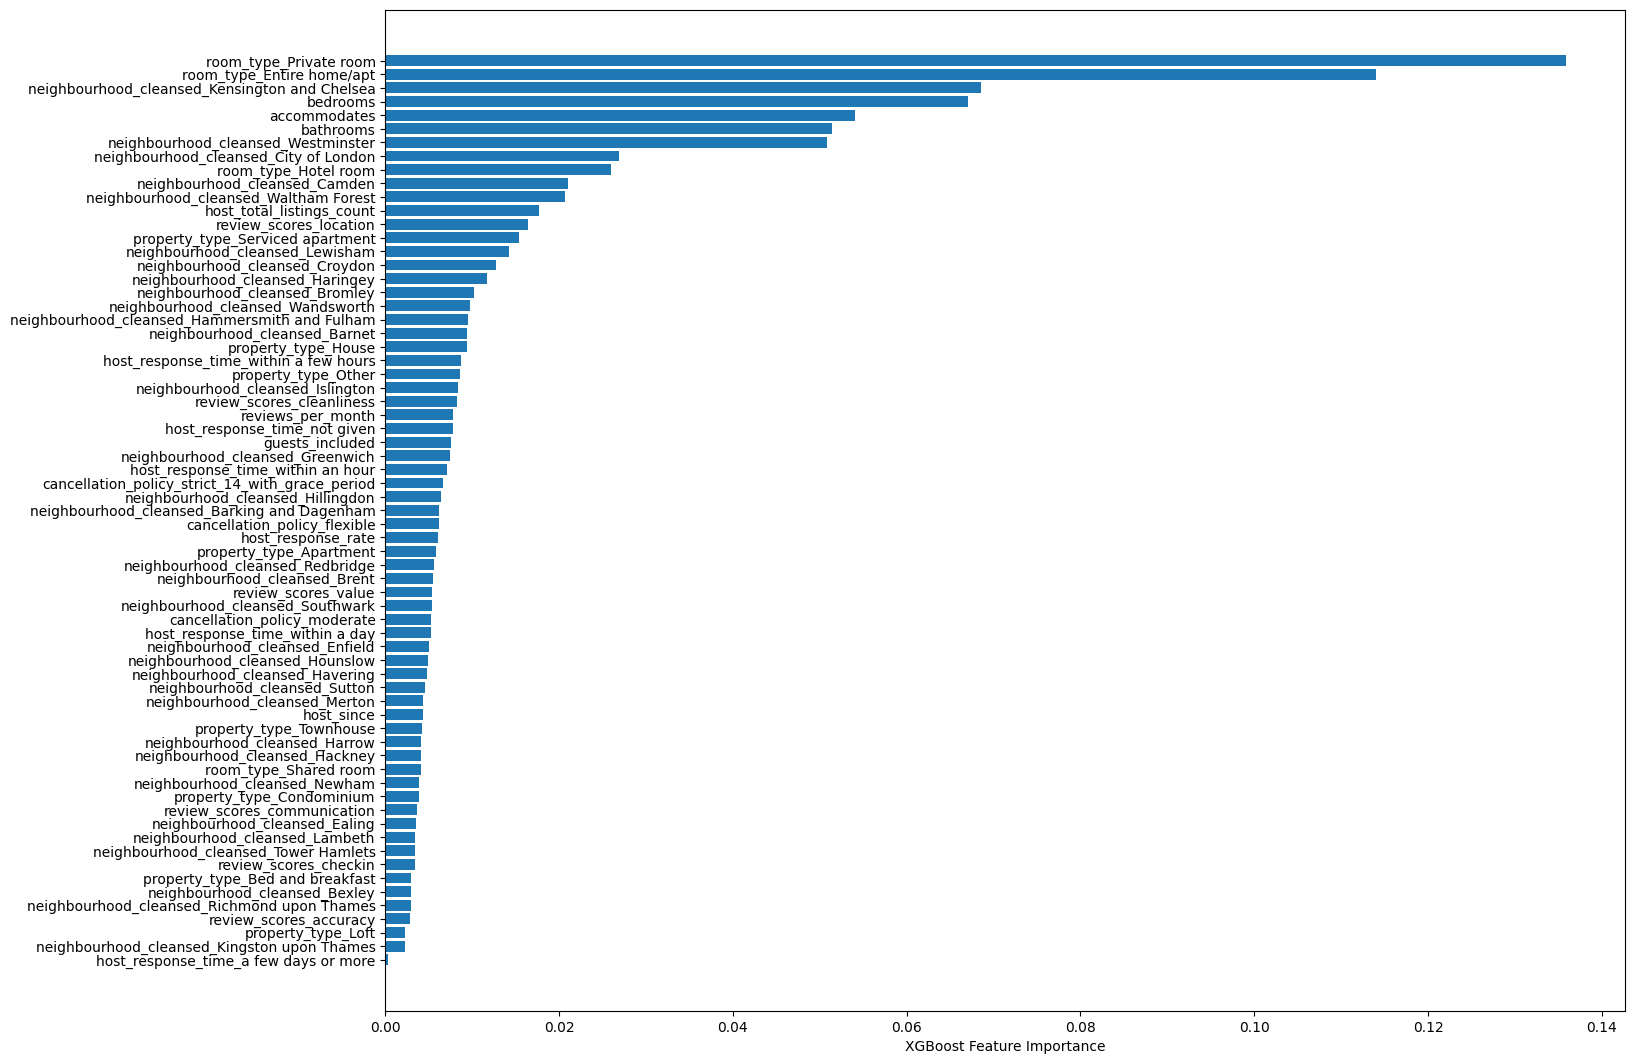

In [ ]:
plt.subplots(figsize=(16, 13))
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(X_train_tab.columns[sorted_idx], model_xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.show();



---



### 4.2 Models for the Text Data

In this Section, I create the models that predict the price based on the text data. First, I apply TextVectorization to each of the preprocessed text features. Then I construct several recurrent neural networks and a BERT model. I compare the performance of each model and select the best performing model for the final model architecture.

I create train and validation set again and because I use the same seed, the observations of `X_train`and `X_train_text` will match up, same for the validation sets.

In [ ]:
X_train_text, X_val_text, _,_= train_test_split(train_processed_text, train_processed_text, test_size = 0.2, random_state = 5)

At first, I decide on a vocabulary size of 15000. It specifies the number of unique tokens that will be included in the vocabulary created by `TextVectorization`. I tried out various other vocabulary sizes but ultimately settled on this amount. `TextVectorization` is a Keras preprocessing layer and takes care of multiple tasks at once. It tokenizes the data, breaking text inputs into single tokens, which can then be used by the neural networks. It also builds a vocabulary during training, which is used to map tokens to their respective inputs. It substitutes each token in the text with the vocabulary's associated integer index. This converts the text data into an integer sequence, with each number representing a token. The function also takes care of padding and truncation. By defining the sequence length shorter sequences padded with zeroes, while longer sequences are truncated. This process makes the data more uniform and allows for more efficiency. `TextVectorization` can also deploy a simple standardization process, but because I standardized the text data at the beginning, I do not use it.

To use the layer, I create a function that applies the vectorization to the train, validation and test text set. I chose the sequence length based on the word count analyzed in Section 3.2.

In [ ]:
# Define the vocab size
vocab_size = 15000

def vectorize_text_data(feature,seq_length):
  vectorize_layer = TextVectorization(standardize=None, max_tokens=vocab_size, output_sequence_length=seq_length)
  vectorize_layer.adapt(X_train_text[feature])
  X_train_text_vectorized = vectorize_layer(X_train_text[feature])
  X_val_text_vectorized = vectorize_layer(X_val_text[feature])
  X_test_text_vectorized = vectorize_layer(test_processed_text[feature])

  print(f'{feature} vectorized')

  return X_train_text_vectorized, X_val_text_vectorized, X_test_text_vectorized

# Vectorize name
seq_length_name = 20
X_train_text_name, X_val_text_name, X_test_text_name = vectorize_text_data('name', seq_length_name)

# Vectorize summary
seq_length_summary = 50
X_train_text_summary, X_val_text_summary, X_test_text_summary = vectorize_text_data('summary', seq_length_summary)

# Vectorize space
seq_length_space = 100
X_train_text_space, X_val_text_space, X_test_text_space = vectorize_text_data('space', seq_length_space)

# Vectorize description
seq_length_description = 150
X_train_text_description, X_val_text_description, X_test_text_description = vectorize_text_data('description', seq_length_description)

# Vectorize neighborhood_overview
seq_length_neighborhood_overview = 100
X_train_text_neighborhood_overview, X_val_text_neighborhood_overview, X_test_text_neighborhood_overview = vectorize_text_data('neighborhood_overview', seq_length_neighborhood_overview)

# Vectorize neighborhood_overview
seq_length_transit = 100
X_train_text_transit, X_val_text_transit, X_test_text_transit = vectorize_text_data('transit', seq_length_transit)

# Vectorize house_ruleas
seq_length_house_rules = 30
X_train_text_house_rules, X_val_text_house_rules, X_test_text_house_rules = vectorize_text_data('house_rules', seq_length_house_rules)

name vectorized
summary vectorized
space vectorized
description vectorized
neighborhood_overview vectorized
transit vectorized
house_rules vectorized


The first RNN model created is an LSTM. The Keras Functional API allows me to train different models on the seven text features simultaneously. The different model results are then concatenated.

The number of hidden units in the GRUs is set to 100, and the final activation functions are set to ReLU, since the price cannot be negative. I again select Adam as the optimizer and choose the mean squared error as the loss function along with a batch size of 256. To avoid overfitting, I use early stopping. Because I choose early stopping, the epoch size becomes less important because the model is likely to stop training before it reaches the 40th epoch.


Another notable aspect of my model is that I chose not to mask zeros. Typically, a masked zero is marked as a special token to be skipped in the embedding layer, since it should not carry any meaningful information. In the case of my models, this option not only led to a much longer training time (300s per epoch), but also to more epochs being stopped, and they ended up having a worse performance. Since I run the different models multiple times to test configurations, I don't use masking.

During model building, I also tested other architectures with dropout layers to avoid overfitting, but they did not provide meaningful performance improvements and were dropped.  Other numbers of hidden units and batch sizes were also tested, but resulted in longer runtimes without significant improvement.

In [ ]:
# Define the inputs
input_name = tf.keras.Input(shape=(seq_length_name,))
input_summary = tf.keras.Input(shape=(seq_length_summary,))
input_space = tf.keras.Input(shape=(seq_length_space,))
input_description = tf.keras.Input(shape=(seq_length_description,))
input_neighborhood_overview = tf.keras.Input(shape=(seq_length_neighborhood_overview,))
input_transit = tf.keras.Input(shape=(seq_length_transit,))
input_house_rules = tf.keras.Input(shape=(seq_length_house_rules,))

# Listing name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_name)(input_name)
LSTM_name = layers.LSTM(100)(name_embeddings)
dense_name = layers.Dense(1, activation='relu')(LSTM_name)

# Summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_summary)(input_summary)
LSTM_summary = layers.LSTM(100)(summary_embeddings)
dense_summary = layers.Dense(1, activation='relu')(LSTM_summary)

# Space
space_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_space)(input_space)
LSTM_space = layers.LSTM(100)(space_embeddings)
dense_space = layers.Dense(1, activation='relu')(LSTM_space)

# Description
description_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_description)(input_description)
LSTM_description = layers.LSTM(100)(description_embeddings)
dense_description = layers.Dense(1, activation='relu')(LSTM_description)

# Neighborhood_overview
neighborhood_overview_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_neighborhood_overview)(input_neighborhood_overview)
LSTM_neighborhood_overview = layers.LSTM(100)(neighborhood_overview_embeddings)
dense_neighborhood_overview = layers.Dense(1, activation='relu')(LSTM_neighborhood_overview)

# Transit
transit_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_transit)(input_transit)
LSTM_transit = layers.LSTM(100)(transit_embeddings)
dense_transit = layers.Dense(1, activation='relu')(LSTM_transit)

# House_rules
house_rules_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_house_rules)(input_house_rules)
LSTM_house_rules = layers.LSTM(100)(house_rules_embeddings)
dense_house_rules = layers.Dense(1, activation='relu')(LSTM_house_rules)

# Concatenate
output_layer = tf.keras.layers.concatenate([dense_name, dense_summary, dense_space, dense_description, dense_neighborhood_overview, dense_transit, dense_house_rules])

model_LSTM = tf.keras.Model(inputs=[input_name, input_summary,input_space,input_description,input_neighborhood_overview,input_transit,input_house_rules], outputs=output_layer)

# Compile
model_LSTM.compile(optimizer="adam",
                   loss="mse",
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_LSTM.summary()

callback = [tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error", patience=3, verbose=1, restore_best_weights=True)]

# Fit the model
model_LSTM.fit([X_train_text_name,X_train_text_summary,X_train_text_space,X_train_text_description,X_train_text_neighborhood_overview,X_train_text_transit, X_train_text_house_rules],
               y_train,
               validation_data=([X_val_text_name, X_val_text_summary, X_val_text_space, X_val_text_description, X_val_text_neighborhood_overview, X_val_text_transit, X_val_text_house_rules], y_val),
               epochs=40,
               batch_size=256,
               callbacks=callback)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 150)]        0           []                               
                                                                                              

For the GRU model, I follow essentially the same structure as the LSTM model for the same reasons.

The GRU model outperforms the LSTM. I ran the models several times, and the GRU model outperformed the LSTM every time, sometimes by a wide margin.

In [ ]:
# Define the inputs
input_name = tf.keras.Input(shape=(seq_length_name,))
input_summary = tf.keras.Input(shape=(seq_length_summary,))
input_space = tf.keras.Input(shape=(seq_length_space,))
input_description = tf.keras.Input(shape=(seq_length_description,))
input_neighborhood_overview = tf.keras.Input(shape=(seq_length_neighborhood_overview,))
input_transit = tf.keras.Input(shape=(seq_length_transit,))
input_house_rules = tf.keras.Input(shape=(seq_length_house_rules,))

# Listing name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_name)(input_name)
GRU_name = layers.GRU(100)(name_embeddings)
dense_name = layers.Dense(1, activation='relu')(GRU_name)

# Summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_summary)(input_summary)
GRU_summary = layers.GRU(100)(summary_embeddings)
dense_summary = layers.Dense(1, activation='relu')(GRU_summary)

# Space
space_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_space)(input_space)
GRU_space = layers.GRU(100)(space_embeddings)
dense_space = layers.Dense(1, activation='relu')(GRU_space)

# Description
description_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_description)(input_description)
GRU_description = layers.GRU(100)(description_embeddings)
dense_description = layers.Dense(1, activation='relu')(GRU_description)

# Neighborhood_overview
neighborhood_overview_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_neighborhood_overview)(input_neighborhood_overview)
GRU_neighborhood_overview = layers.GRU(100)(neighborhood_overview_embeddings)
dense_neighborhood_overview = layers.Dense(1, activation='relu')(GRU_neighborhood_overview)

# Transit
transit_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_transit)(input_transit)
GRU_transit = layers.GRU(100)(transit_embeddings)
dense_transit = layers.Dense(1, activation='relu')(GRU_transit)

# House_rules
house_rules_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_house_rules)(input_house_rules)
GRU_house_rules = layers.GRU(100)(house_rules_embeddings)
dense_house_rules = layers.Dense(1, activation='relu')(GRU_house_rules)

# Concatenate
output_layer = tf.keras.layers.concatenate([dense_name, dense_summary, dense_space, dense_description, dense_neighborhood_overview, dense_transit])

model_GRU = tf.keras.Model(inputs=[input_name, input_summary,input_space,input_description,input_neighborhood_overview,input_transit,input_house_rules], outputs = output_layer)

# Compile
model_GRU.compile(optimizer="adam",
              loss="mse",
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_GRU.summary()
callback = [tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error", patience=3, verbose=1, restore_best_weights=True)]

# Fit the model
model_GRU.fit([X_train_text_name,X_train_text_summary,X_train_text_space,X_train_text_description,X_train_text_neighborhood_overview,X_train_text_transit, X_train_text_house_rules],
          y_train,
          validation_data=([X_val_text_name, X_val_text_summary, X_val_text_space, X_val_text_description, X_val_text_neighborhood_overview, X_val_text_transit, X_val_text_house_rules], y_val),
          epochs = 40,
          batch_size = 256,
          callbacks=callback)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 150)]        0           []                               
                                                                                            

Since the GRU outperforms the LSTM, I next build a bidirectional GRU.

In a conventional GRU, information travels through the network in one direction, from the beginning to the end of the input sequence. In a bidirectional GRU, information travels through the network in two directions: from the beginning to the end of the input sequence, and from the end to the beginning of the input sequence. The latter is often more computationally intensive, but can result in better performance than a standard GRU.

In this case, the bidirectional GRU significantly outperforms the GRU, all other parameters being the same.

In [ ]:
# Define the inputs
input_name = tf.keras.Input(shape=(seq_length_name,))
input_summary = tf.keras.Input(shape=(seq_length_summary,))
input_space = tf.keras.Input(shape=(seq_length_space,))
input_description = tf.keras.Input(shape=(seq_length_description,))
input_neighborhood_overview = tf.keras.Input(shape=(seq_length_neighborhood_overview,))
input_transit = tf.keras.Input(shape=(seq_length_transit,))
input_house_rules = tf.keras.Input(shape=(seq_length_house_rules,))

# Listing name
name_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_name)(input_name)
GRU_name = layers.Bidirectional(layers.GRU(100), merge_mode="concat")(name_embeddings)
dense_name = layers.Dense(1, activation='relu')(GRU_name)

# Summary
summary_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_summary)(input_summary)
GRU_summary = layers.Bidirectional(layers.GRU(100), merge_mode="concat")(summary_embeddings)
dense_summary = layers.Dense(1, activation='relu')(GRU_summary)

# Space
space_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_space)(input_space)
GRU_space = layers.Bidirectional(layers.GRU(100), merge_mode="concat")(space_embeddings)
dense_space = layers.Dense(1, activation='relu')(GRU_space)

# Description
description_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_description)(input_description)
GRU_description = layers.Bidirectional(layers.GRU(100), merge_mode="concat")(description_embeddings)
dense_description = layers.Dense(1, activation='relu')(GRU_description)

# Neighborhood_overview
neighborhood_overview_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_neighborhood_overview)(input_neighborhood_overview)
GRU_neighborhood_overview = layers.Bidirectional(layers.GRU(100), merge_mode="concat")(neighborhood_overview_embeddings)
dense_neighborhood_overview = layers.Dense(1, activation='relu')(GRU_neighborhood_overview)

# Transit
transit_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_transit)(input_transit)
GRU_transit = layers.Bidirectional(layers.GRU(100), merge_mode="concat")(transit_embeddings)
dense_transit = layers.Dense(1, activation='relu')(GRU_transit)

# House_rules
house_rules_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length_house_rules)(input_house_rules)
GRU_house_rules = layers.Bidirectional(layers.GRU(100), merge_mode="concat")(house_rules_embeddings)
dense_house_rules = layers.Dense(1, activation='relu')(GRU_house_rules)

# Concatenate
output_layer = tf.keras.layers.concatenate([dense_name, dense_summary, dense_space, dense_description, dense_neighborhood_overview, dense_transit])

model_biGRU = tf.keras.Model(inputs=[input_name, input_summary,input_space,input_description,input_neighborhood_overview,input_transit,input_house_rules], outputs = output_layer)

# Compile
model_biGRU.compile(optimizer="adam",
              loss="mse",
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model_biGRU.summary()
callback = [tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error", patience=3, verbose=1, restore_best_weights=True)]

# Fit the model
model_biGRU.fit([X_train_text_name,X_train_text_summary,X_train_text_space,X_train_text_description,X_train_text_neighborhood_overview,X_train_text_transit, X_train_text_house_rules],
          y_train,
          validation_data=([X_val_text_name, X_val_text_summary, X_val_text_space, X_val_text_description, X_val_text_neighborhood_overview, X_val_text_transit, X_val_text_house_rules], y_val),
          epochs = 30,
          batch_size = 256,
          callbacks=callback)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 150)]        0           []                               
                                                                                              

After creating the RNNs, I now use a BERT model. Since the BERT model does the preprocessing separately, I use the raw text features that were not preprocessed. I follow the 10. ADAMS tutorial. First, I combine the different text features into a single text feature for each data set.

I set the batch size to 32. This is the number of data samples that will be processed in each iteration during model training. I then create the bert inputs using the corresponding function, which creates a TensorFlow dataset, batches the data into smaller groups, and prefetches the data, which helps with overlapping data loading.

I then load a preprocessor that processes the data and loads a pre-trained BERT model as the base architecture for text encoding. It is important to note that this model is not pre-trained on AirBnB specific text. I then pass the pooled outputs through several dense and dropout layers using ReLU as the activation function. The last layer is a regression output layer to predict the price.

As in the tutorial, I create an optimizer with a custom learning rate schedule. I choose a number of ten epochs, and as with the RNNs, I use early stopping.

The BERT model performs much better than the previous RNNs. Therefore, I will use it in the final model architecture.

In [ ]:
# Combine all text features into one feature
train_combined_text = (X_train['name'] +' '+ X_train['summary']+' '+ X_train['space']+' '+ X_train['description']+' '+ X_train['neighborhood_overview']+' '+ X_train['transit']+' '+ X_train['house_rules']).apply(lambda row: row.strip())
val_combined_text = (X_val['name'] +' '+ X_val['summary']+' '+ X_val['space']+' '+ X_val['description']+' '+ X_val['neighborhood_overview']+' '+ X_val['transit']+' '+ X_val['house_rules']).apply(lambda row: row.strip())
test_combined_text = (test['name'] +' '+ test['summary']+' '+ test['space']+' '+ test['description']+' '+ test['neighborhood_overview']+' '+ test['transit']+' '+ test['house_rules']).apply(lambda row: row.strip())

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Create the inputs
def create_bert_input(dataset, labels, batch_size=batch_size, buffer_size=AUTOTUNE):
    bert_input = tf.data.Dataset.from_tensor_slices((dataset, labels))
    bert_input = bert_input.batch(batch_size)
    bert_input = bert_input.prefetch(buffer_size=buffer_size)
    return bert_input

X_train_bert = create_bert_input(train_combined_text, y_train)
X_val_bert = create_bert_input(val_combined_text, y_val)
X_test_bert = create_bert_input(test_combined_text, None)

# Define input
input_combined = tf.keras.layers.Input(shape=(), dtype=tf.string)

# Add preprocessing layer and input text
preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

# Apply preprocessing to each input feature
encoder_inputs = preprocessor(input_combined)

# Add encoding layer and feed preprocessed text into layer
encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', trainable=True)
# Encode each input feature
outputs = encoder(encoder_inputs)

pooled = outputs['pooled_output']
pooled = tf.keras.layers.Dropout(0.1)(pooled)

# Create the output layer which is the final classifier
dense_layer = tf.keras.layers.Dense(128, activation='relu')(pooled)
dense_layer = tf.keras.layers.Dropout(0.1)(dense_layer)
dense_layer = tf.keras.layers.Dense(64, activation='relu')(dense_layer)
dense_layer = tf.keras.layers.Dropout(0.1)(dense_layer)
dense_layer = tf.keras.layers.Dense(32, activation='relu')(dense_layer)
dense_layer = tf.keras.layers.Dropout(0.1)(dense_layer)
output_layer = tf.keras.layers.Dense(1, activation='linear')(dense_layer)
bert_model = tf.keras.Model(input_combined, outputs=output_layer)
bert_model.summary()


epochs = 10

# Calculate steps_per_epoch based on the cardinality of X_train_combined
steps_per_epoch = tf.data.experimental.cardinality(X_train_bert).numpy()

# Calculate num_train_steps and num_warmup_steps
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

# Set the initial learning rate
init_lr = 3e-5

# Create the optimizer with custom learning rate schedule
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

# Compile the model with the new optimizer, loss, and metrics
bert_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
callback = [tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error", patience=3, verbose=1, restore_best_weights=True)]

# Fit the combined model
history_bert = bert_model.fit(
    X_train_bert,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=X_val_bert,
    callbacks=callback
)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  



---



---



## 5. Final Model Architecture
The final model consists of the BERT model used in the previous section, the XGBoost model using the hyperparameters found during the randomized search, and a deep neural network that serves as a meta-model to make the final prediction based on the BERT and XGB predictions.

In order not to overload the notebook, I do not run the BERT model a second time, but use the same one from Section 4.2.

First, I predict the prices based on the train and the validation set, using both BERT and XGB.

In [ ]:
BERT_predictions_train = bert_model.predict(X_train_bert)
BERT_predictions_val = bert_model.predict(X_val_bert)

346/346 [==============================] - 50s 144ms/step


In [ ]:
model_xgb = xgb.XGBRegressor(learning_rate = 0.078, max_depth=6, n_estimators = 590)
model_xgb.fit(X_train_tab_scaled,y_train)
XGB_predictions_train = model_xgb.predict(X_train_tab_scaled)
XGB_predictions_val = model_xgb.predict(X_val_tab_scaled)
print(f'-XGB RMSE on Train {np.sqrt(mean_squared_error(y_train,XGB_predictions_train)):.4f}')
print(f'-XGB RMSE on Val {np.sqrt(mean_squared_error(y_val,XGB_predictions_val)):.4f}')

-XGB RMSE on Train 40.5379
-XGB RMSE on Val 48.7218


The meta-model takes predictions based on the training set as input and concatenates them. Since this task is fairly straightforward, I decide to use two hidden layers with 64 and 32 hidden units, respectively, and a ReLU activation function. The output layer uses a linear activation function. Again, I use the early stopping function used in all other models, and I use the validation set predictions as validation data. I also use a batch size of 8 and a number of epochs of 20.

In [ ]:
xgb_input = tf.keras.Input(shape=(1,))
bert_input = tf.keras.Input(shape=(BERT_predictions_train.shape[1],))

# Concatenate the predictions as features
concat = tf.keras.layers.concatenate([xgb_input, bert_input])

# Create a neural network for meta-model
meta_model = layers.Dense(64, activation="relu")(concat)
meta_model = layers.Dense(32, activation="relu")(meta_model)
meta_model = layers.Dense(1, activation="linear")(meta_model)  # Assuming regression task

# Create the meta-model
meta_model = tf.keras.Model(inputs=[xgb_input, bert_input], outputs=meta_model)

# Compile the meta-model
meta_model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
meta_model.summary()
callback = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True)]


# Train the meta-model
meta_model.fit([XGB_predictions_train, BERT_predictions_train],
               y_train,
               validation_data=([XGB_predictions_val, BERT_predictions_val], y_val),
               epochs=20,
               callbacks=callback,
               batch_size=8
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           192         ['concatenate[0][0]']      

I now create XGB and BERT predictions based on the test data set.

In [ ]:
XGB_predictions_test = model_xgb.predict(X_test_tab_scaled)

In [ ]:
BERT_predictions_test = bert_model.predict(X_test_bert)

931/931 [==============================] - 186s 198ms/step


The predictions based on the test data are fed into the meta-model to create the final predictions. I then create the submission CSV file to get the RMSE score on the test set found on Kaggle. The final model achieves an RMSE of 45.58 on the hidden test set and outperforms the individual models.

In [ ]:
meta_predictions = meta_model.predict([XGB_predictions_test, BERT_predictions_test])
prediction = pd.DataFrame(test.listing_id,columns=['listing_id'])
prediction['price'] = meta_predictions
prediction.to_csv('submission.csv', index = False)

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7e1688fefac0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
931/931 [==============================] - 2s 2ms/step




---



---



## 6. Conclusion
In this assignment, I used linear, ensemble, deep neural networks, recurrent neural networks, and a BERT model to predict AirBnB listing prices. The XGBoost model outperformed the other ensemble models and a deep neural network. This model alone achieved a score of 47.88 on the hidden test data. Transformers are currently the state of the art models for natural language processing, and as expected, the BERT model outperformed the recurrent neural networks by a wide margin.

Although I used a wide range of models, my architecture can still be improved. The BERT model was not pre-trained on AirBnB specific listings, but on more general text. As such, it is likely to perform slightly worse. Also, I did not use the review data set that was provided. Using it will probably improve the performance of the BERT model, as it provides much more text compared to the texts used in my prediction models. Another possible improvement is data cleaning. Different approaches could further improve the performance as my focus was not on the cleaning part. Using mini-models to predict the missing values and including more features may lead to different results.

However, despite these considerations, I believe that my model performs comparably well and I was able to gain more insight into how NLP models work.